
# Natural Language Processing

## Sentiment analysis with confusion matrix, ROC/AUC, and lift chart

## Imports

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

We need to import several things from Keras.

In [19]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam, Ftrl, Adamax, SGD, Adadelta, Nadam, Optimizer, RMSprop, Adagrad
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,CSVLogger, ReduceLROnPlateau,TensorBoard, LambdaCallback

from tensorflow.keras import backend as K
from tensorflow.keras.activations import relu, sigmoid ,softmax, tanh, hard_sigmoid, softsign, softplus, linear

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model

import skopt

from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args
import sklearn.model_selection as sk
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
##import scikit-optimize as skplt
import matplotlib.pyplot as plt

This was developed using Python 3.6 (Anaconda) and package versions:

In [20]:
tf.__version__

'2.0.0'

In [21]:
tf.keras.__version__

'2.2.4-tf'

In [22]:
skopt.__version__

'0.9.0'

In [23]:
##sklearn.model_selection.__version__

## Load Data

For Training use the twitter data set with sentiment analysis

In [24]:
import pandas as pd

file = '/Volumes/Elements/GitHub/twitter-project/Data Files/twitter_sentiment_learn.csv'

learning_df = pd.read_csv(file)
print(learning_df.shape)
##print(learning_df.head())

(385042, 6)


## This next section changes the neg/neu/pos column values into a bad/meh/good with a 1 in the highest value
## and a 0 in the other three. 
## This allows for creating a confusion matrix

## Load the training- and test-sets.

In [25]:
x = learning_df['text'].to_list()



learning_df[["bad", "meh", "good"]] = 0
for i in range(learning_df.shape[0]):
    if (learning_df.loc[i,"NEG"] >= learning_df.loc[i,"NEU"]) and (learning_df.loc[i,"NEG"] >= learning_df.loc[i,"POS"]):
        learning_df.loc[i,"bad"] = 1
    elif (learning_df.loc[i,"NEU"] >= learning_df.loc[i,"NEG"]) and (learning_df.loc[i,"NEU"] >= learning_df.loc[i,"POS"]):
        learning_df.loc[i,"meh"] = 1
    else:
        learning_df.loc[i,"good"] = 1

y = learning_df[["bad", "meh", "good"]]


##y = tarmac

x_train,x_test,y_train,y_test= sk.train_test_split(x,y,test_size=0.20, random_state = 42)

# Convert to numpy arrays.
y_train = np.array(y_train)
y_test = np.array(y_test)
##print(x[1])

print("Train-set size: ", len(x_train))
print("Test-set size:  ", len(x_test))

data_text = x_train + x_test

Train-set size:  308033
Test-set size:   77009


In [26]:
data_text = x_train + x_test

Print an example from the training-set to see that the data looks correct.

In [27]:
##print("\n", x_train[1])
##print("\n", learning_df.head())
##print("\n", y_train[1:5])

The true "class" is a sentiment of the movie-review. In this case 0,1,0 means a "meh" review out of bad, meh, good

In [28]:
y_train[1]

array([0, 1, 0])

Tokenize the test and training data

In [29]:
## can be played with 

num_words = 30000

tokenizer = Tokenizer(num_words=num_words,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None)

##%%time
tokenizer.fit_on_texts(data_text)

x_train_tokens = tokenizer.texts_to_sequences(x_train)

x_test_tokens = tokenizer.texts_to_sequences(x_test)

## Padding and Truncating Data

In this case we need to convert tokens to an array so we can do some quick math to determine what amount of padding to use

In [30]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

The average number of tokens in a sequence is:

In [31]:
np.mean(num_tokens)

15.617023597425735

The maximum number of tokens in a sequence is:

In [32]:
np.max(num_tokens)

36

### The max number of tokens we will allow is set to the average plus 3 standard deviations.


# In this case, try the full amount

In [33]:
##max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
max_tokens = np.max(num_tokens)
max_tokens = math.floor(max_tokens)

Now use "pre" for padding

In [34]:
pad = 'pre'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
print("the padded training set has dimensions ," x_train_pad.shape)
print("the padded test set has dimensions ," x_test_pad.shape)

SyntaxError: invalid syntax (3403434483.py, line 6)

## Tokenizer Inverse Map

For some strange reason, the Keras implementation of a tokenizer does not seem to have the inverse mapping from integer-tokens back to words, which is needed to reconstruct text-strings from lists of tokens. So we make that mapping here.

In [ ]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

Helper-function for converting a list of tokens back to a string of words.

In [ ]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]
    
    # Concatenate all words.
    text = " ".join(words)

    return text

For example, this is the original text from the data-set:

In [ ]:
x_train[1]

'RT @khsaddampti: Indian army caputred hyderabad through operation polo #SunderLalCommissionReport https://t.co/c6XBmHyh46'

We can recreate this text except for punctuation and other symbols, by converting the list of tokens back to words:

In [ ]:
tokens_to_string(x_train_tokens[1])

'rt indian army hyderabad through operation polo sunderlalcommissionreport https t co'

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. See Tutorial #03-C for a tutorial on Keras.

In [ ]:
model = Sequential()

In [ ]:
figure_of_merit = 2 * max_tokens ## was 100
first_layer = math.floor(max_tokens/2) + 2
second_layer = math.floor(max_tokens/3) + 2
third_layer = math.floor(max_tokens/4) + 3
fourth_layer = math.floor(max_tokens/5) + 3
embedding_size = figure_of_merit

The embedding-layer also needs to know the number of words in the vocabulary (`num_words`) and the length of the padded token-sequences (`max_tokens`). We also give this layer a name because we need to retrieve its weights further below.

In [ ]:
model.add(Embedding(input_dim=num_words,## was num_words
                    output_dim=embedding_size,                    
                    input_length=max_tokens,
                   name='layer_embedding'))
##model.add(Flatten())

##model = tf.keras.Sequential([
##    tf.keras.layers.Embedding(input_dim = num_words, output_dim = embedding_size, input_length=max_tokens),
##    tf.keras.layers.Flatten(),
##    tf.keras.layers.Dense(30, activation='relu'),
##    tf.keras.layers.Dense(60, activation='sigmoid')
##    tf.keras.layers.Dense(15, activation='relu')
##    tf.keras.layers.Dense(3, activation='sigmoid')
##])

2022-04-18 14:14:04.581730: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-18 14:14:04.582420: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 16. Tune using inter_op_parallelism_threads for best performance.


We can now add the first Gated Recurrent Unit (GRU) to the network. This will have 16 outputs. Because we will add a second GRU after this one, we need to return sequences of data because the next GRU expects sequences as its input.

In [ ]:
model.add(GRU(units=first_layer, 
              activation = 'tanh', ## was tanh
              recurrent_activation = 'softmax', 
              return_sequences=True))
##model.add(Dense(first_layer, activation='softmax'))

This adds the second GRU with 8 output units. This will be followed by another GRU so it must also return sequences.

In [ ]:
model.add(GRU(units=second_layer, activation = 'tanh' , ## was tanh
              recurrent_activation = 'softmax', 
              return_sequences=True))
##model.add(Dense(second_layer, activation='sigmoid'))

This adds the third and final GRU with 4 output units. This will be followed by a dense-layer, so it should only give the final output of the GRU and not a whole sequence of outputs.

In [ ]:
model.add(GRU(units=third_layer, activation = 'tanh', ## was tanh
              recurrent_activation = 'softmax', 
              return_sequences = True))
model.add(GRU(units=fourth_layer, activation = 'tanh', ## was tanh
              recurrent_activation = 'sigmoid', return_sequences = False))

## Add a fully-connected / dense layer which computes a value between 0 and 1.0 that will be used as the classification output.

In [ ]:
model.add(Dense(3, activation='softmax')) ## was 3

Use the Adam optimizer with the given learning-rate.

In [ ]:
learning_rat = 1e-3
optimizer = Nadam(learning_rate=learning_rat)

Compile the Keras model so it is ready for training.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
             metrics=['accuracy'])
##model.compile(loss='binary_crossentropy',
##              optimizer=optimizer,
##              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 36, 72)            2160000   
_________________________________________________________________
gru (GRU)                    (None, 36, 20)            5640      
_________________________________________________________________
gru_1 (GRU)                  (None, 36, 14)            1512      
_________________________________________________________________
gru_2 (GRU)                  (None, 36, 12)            1008      
_________________________________________________________________
gru_3 (GRU)                  (None, 10)                720       
_________________________________________________________________
dense (Dense)                (None, 3)                 33        
Total params: 2,168,913
Trainable params: 2,168,913
Non-trainable params: 0
______________________________________________

## make callbacks

In [ ]:
callbackx = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                             patience =1,
                                            restore_best_weights = True)
        
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.95):
      print("\nReached 95% val_accuracy, so slowing the learning rate and keeping Nadam optimizer.")
      optimizer = Nadam(learning_rate = 0.4*learning_rat)
      self.model.stop_training = False
    if(logs.get('val_accuracy') > 0.970):
      print("\nReached 987 val_accuracy, so slowing the learning rate and keeping Nadam optimizer.")
      optimizer = Nadam(learning_rate = 0.1*learning_rat)
      self.model.stop_training = False
call_it = myCallback()

## Train the Recurrent Neural Network

We can now train the model. Note that we are using the data-set with the padded sequences. We use 5% of the training-set as a small validation-set, so we have a rough idea whether the model is generalizing well or if it is perhaps over-fitting to the training-set.

%%time
model.fit(x_train_pad, y_train,
          validation_split=0.15, epochs=10, batch_size= 256,
            callbacks = [callbackx, call_it])

## Performance on Test-Set

Now that the model has been trained we can calculate its classification accuracy on the test-set.

In [ ]:
%%time
model.fit(x_train_pad, y_train,
          validation_split=0.25, epochs=40, batch_size=100, verbose = 2,
            callbacks = [call_it, callbackx])
### The above is the historical, the below is the search for optimization

search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected of improvement.
                            n_calls=11,
                            x0=default_parameters)

Train on 231024 samples, validate on 77009 samples
Epoch 1/40


2022-04-18 14:14:10.253574: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_gru_with_fallback_6612_6751' and '__inference___backward_standard_gru_6867_7426_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_9726' both implement 'gru_61379f0c-fafa-4545-ab2e-fd622bf8546c' but their signatures do not match.
2022-04-18 14:27:10.023008: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_gru_with_fallback_17545' and '__inference_standard_gru_17456_specialized_for_sequential_gru_3_StatefulPartitionedCall_at___inference_distributed_function_17769' both implement 'gru_abb26475-fdf5-4d30-a92e-99f799578f7d' but their signatures do not match.



Reached 95% val_accuracy, so slowing the learning rate and keeping Nadam optimizer.
231024/231024 - 1054s - loss: 0.2219 - accuracy: 0.9252 - val_loss: 0.1398 - val_accuracy: 0.9587
Epoch 2/40

Reached 95% val_accuracy, so slowing the learning rate and keeping Nadam optimizer.
231024/231024 - 921s - loss: 0.1078 - accuracy: 0.9687 - val_loss: 0.1273 - val_accuracy: 0.9631
Epoch 3/40

Reached 95% val_accuracy, so slowing the learning rate and keeping Nadam optimizer.
231024/231024 - 941s - loss: 0.0854 - accuracy: 0.9761 - val_loss: 0.1272 - val_accuracy: 0.9627
CPU times: user 2h 25min 38s, sys: 7h 10min 22s, total: 9h 36min
Wall time: 48min 36s


In [ ]:

result = model.evaluate(x_test_pad, y_test)
print("and now")

77009/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [ ]:
print("Accuracy: {0:.2%}".format(result[1]))





Accuracy: 96.42%


## save model

In [ ]:
##from keras.models import models_from_json
model_json = model.to_json()
with open ("model_cat.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_cat.h5")

model.save("model_cat.h5")
print(model_json)
print("saved model")

{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "Embedding", "config": {"name": "layer_embedding", "trainable": true, "batch_input_shape": [null, 36], "dtype": "float32", "input_dim": 30000, "output_dim": 72, "embeddings_initializer": {"class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}}, "embeddings_regularizer": null, "activity_regularizer": null, "embeddings_constraint": null, "mask_zero": false, "input_length": 36}}, {"class_name": "GRU", "config": {"name": "gru", "trainable": true, "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 20, "activation": "tanh", "recurrent_activation": "softmax", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer":

## Example of Mis-Classified Text

In order to show an example of mis-classified text, we first calculate the predicted sentiment for the first 1000 texts in the test-set.

In [ ]:
## Load the saved model and see if the results differ

model_file = 'model_cat.h5'

loaded_model = load_model(
    model_file,
    custom_objects = None,
    compile = True
)



AttributeError: 'str' object has no attribute 'decode'

In [ ]:
%%time
##y_pred = model.predict(x=x_test_pad[0:1000])
##y_pred = loaded_model.predict(x=x_test_pad[0:1000])
##y_pred = y_pred.T[0]


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs


These predicted numbers fall between 0.0 and 1.0. We use a cutoff / threshold and say that all values above 0.5 are taken to be 1.0 and all values below 0.5 are taken to be 0.0. This gives us a predicted "class" of either 0.0 or 1.0.

## Load the model and use that to create a confusion matrix

In [ ]:
preddy = loaded_model.predict(x_test_pad)

preddy = np.array(preddy)

catzy_df = pd.DataFrame(preddy, columns = ['NEG', 'NEU', 'POS'])

catzy_df[["neg", "neu", "pos"]] = 0
for i in range(catzy_df.shape[0]):
    if (catzy_df.loc[i,"NEG"] >= catzy_df.loc[i,"NEU"]) and (catzy_df.loc[i,"NEG"] >= catzy_df.loc[i,"POS"]):
        catzy_df.loc[i,"neg"] = 1
    elif (catzy_df.loc[i,"NEU"] >= catzy_df.loc[i,"NEG"]) and (catzy_df.loc[i,"NEU"] >= catzy_df.loc[i,"POS"]):
        catzy_df.loc[i,"neu"] = 1
    else:
        catzy_df.loc[i,"pos"] = 1

preddy = catzy_df[["neg", "neu", "pos"]]



print("The head of preddy is \n",preddy.head())
##print("The head of y_test is \n",y_test.head())

The head of preddy is 
    neg  neu  pos
0    0    0    1
1    0    1    0
2    0    0    1
3    0    1    0
4    0    1    0


Precision                                   : 0.964
Recall                                      : 0.964
F1-Score                                    : 0.964

Precision Recall F1-Score Support Per Class : 
 (0.9643557657692405, 0.9644976561181161, 0.9643414271983108, None)

Classification Report                       : 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90      4338
           1       0.97      0.98      0.97     46728
           2       0.96      0.95      0.96     25943

   micro avg       0.96      0.96      0.96     77009
   macro avg       0.95      0.94      0.95     77009
weighted avg       0.96      0.96      0.96     77009
 samples avg       0.96      0.96      0.96     77009

the value counts for turkey are 
 1    47315
2    25618
0     4076
dtype: int64
the value counts for doggy are 
 1    46728
2    25943
0     4338
dtype: int64


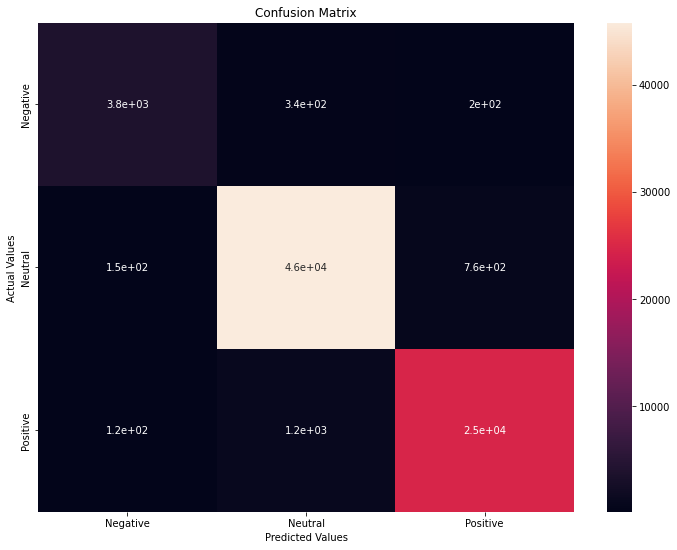

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support, multilabel_confusion_matrix

print('Precision                                   : %.3f'%precision_score(y_test, preddy, average = 'weighted'))
print('Recall                                      : %.3f'%recall_score(y_test, preddy, average = 'weighted'))
print('F1-Score                                    : %.3f'%f1_score(y_test, preddy, average = 'weighted'))
print('\nPrecision Recall F1-Score Support Per Class : \n',precision_recall_fscore_support(y_test, preddy, average = 'weighted'))
print('\nClassification Report                       : ')
print(classification_report(y_test, preddy))


turkey = 0*preddy['neg'] + preddy['neu'] + 2*preddy['pos']

print("the value counts for turkey are \n", turkey.value_counts())

grubby = np.array(y_test)

y_catty = pd.DataFrame(grubby, columns = ['neg', 'neu', 'pos'])

doggy = 0*y_catty['neg'] + y_catty['neu'] + 2*y_catty['pos']

print("the value counts for doggy are \n", doggy.value_counts())

##cm = multilabel_confusion_matrix(y_true=y_test, y_pred=preddy)

import seaborn as sns

cm = confusion_matrix(doggy, turkey)
cm_df = pd.DataFrame(cm,
                     index = ['Negative','Neutral','Positive'], 
                     columns = ['Negative','Neutral','Positive'])

plt.figure(figsize=(12,9))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


## New Data

Let us try and classify new texts that we make up. Some of these are obvious, while others use negation and sarcasm to try and confuse the model into mis-classifying the text.

## Let's do Amazon with the category stuff

In [ ]:
amzn_file = '/Volumes/Elements/GitHub/twitter-project/Data Files/Amazon_df_json.csv'

amzn_df =  pd.read_csv(amzn_file, header=0, index_col=0, parse_dates=True)

am_columns = ['numbers', 'created_at','full_text', 'retweet_count', 'user_id', 
           'user.favourites_count', 'user.followers_count', 'AMZN', 'Amazon', 'dupe']
amzn_df.columns = am_columns

amzn_text = amzn_df['full_text'].astype(str)


amzn_x = amzn_text.to_list()

bob = amzn_x[0:7]

print(type(bob))

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

##%%time
tokenizer.fit_on_texts(amzn_x)

amzn_train_tokens = tokenizer.texts_to_sequences(amzn_x)

amzn_pad = pad_sequences(amzn_train_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

amzn_sent = loaded_model.predict(x=amzn_pad)

print(amzn_sent[1:3])

predictions = pd.DataFrame(amzn_sent, columns  = ['neg', 'neu', 'pos'])

amzn_df_nn = amzn_df.join(predictions)
amzn_df_nn.columns = ['number','created_at','full_text', 'retweet_count', 'user_id', 'user.favourites_count', 'user.followers_count','Symbol','Name', 'dupe', 'neg', 'neu', 'pos']

##    print("\nThe head of the ", i, " dataframe is \n", Krusty[i].head())

amzn_df_nn.to_csv('/Volumes/Elements/GitHub/twitter-project/Data Files/Amazon_nn_scored_cat.csv', header = True)

print('the shape of Amazon_df_nn is ', amzn_df_nn.shape)

/var/folders/3q/y2fjlm8n4752m4cv89kq3r0h0000gn/T/ipykernel_50436/3546143532.py:3: DtypeWarning: Columns (1,4,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  amzn_df =  pd.read_csv(amzn_file, header=0, index_col=0, parse_dates=True)


<class 'list'>
[[0.0266369  0.8686406  0.10472256]
 [0.00226565 0.53041273 0.46732166]]
the shape of Amazon_df_nn is  (357661, 13)


## KMI 

In [ ]:
KMI_file = '/Volumes/Elements/GitHub/twitter-project/Data Files/KMI_df_json.csv'

KMI_df =  pd.read_csv(KMI_file, header=0, index_col=0, parse_dates=True)

KMI_columns = ['numbers', 'created_at','full_text', 'retweet_count', 'user_id', 
           'user.favourites_count', 'user.followers_count', 'KMI', 'Kinder_Morgan', 'dupe']
KMI_df.columns = KMI_columns

KMI_text = KMI_df['full_text'].astype(str)


KMI_x = KMI_text.to_list()

print(type(KMI_x))

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

##%%time
tokenizer.fit_on_texts(KMI_x)

KMI_train_tokens = tokenizer.texts_to_sequences(KMI_x)

KMI_pad = pad_sequences(KMI_train_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

KMI_sent = loaded_model.predict(x=KMI_pad)

print(KMI_sent[1:3])

predictions = pd.DataFrame(KMI_sent, columns  = ['neg', 'neu', 'pos'])

KMI_df_nn = KMI_df.join(predictions)
KMI_df_nn.columns = ['number','created_at','full_text', 'retweet_count', 'user_id', 'user.favourites_count', 'user.followers_count','Symbol', 'Name','dupe', 'neg', 'neu', 'pos']

##    print("\nThe head of the ", i, " dataframe is \n", Krusty[i].head())

KMI_df_nn.to_csv('/Volumes/Elements/GitHub/twitter-project/Data Files/KMI_nn_scored_cat.csv', header = True)

print('the shape of KMI _df_nn is ', KMI_df_nn.shape)

<class 'list'>
[[0.00105768 0.0034797  0.9954626 ]
 [0.00344977 0.14006977 0.8564805 ]]
the shape of KMI _df_nn is  (6360, 13)


## CrowdSource

In [ ]:
CRWD_file = '/Volumes/Elements/GitHub/twitter-project/Data Files/CRWD_df_json.csv'

CRWD_df =  pd.read_csv(CRWD_file, header=0, index_col=0, parse_dates=True)

CRWD_columns = ['numbers', 'created_at','full_text', 'retweet_count', 'user_id', 
           'user.favourites_count', 'user.followers_count', 'CRWD', 'CrowdSource', 'dupe']
CRWD_df.columns = CRWD_columns

CRWD_text = CRWD_df['full_text'].astype(str)


CRWD_x = CRWD_text.to_list()

print(type(CRWD_x))

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

##%%time
tokenizer.fit_on_texts(CRWD_x)

CRWD_train_tokens = tokenizer.texts_to_sequences(CRWD_x)

CRWD_pad = pad_sequences(CRWD_train_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

CRWD_sent = loaded_model.predict(x=CRWD_pad)

print(CRWD_sent[1:3])

predictions = pd.DataFrame(CRWD_sent, columns  = ['neg', 'neu', 'pos'])

CRWD_df_nn = CRWD_df.join(predictions)
CRWD_df_nn.columns = ['number','created_at','full_text', 'retweet_count', 'user_id', 'user.favourites_count', 'user.followers_count','Symbol', 'Name','dupe', 'neg', 'neu', 'pos']

##    print("\nThe head of the ", i, " dataframe is \n", Krusty[i].head())

CRWD_df_nn.to_csv('/Volumes/Elements/GitHub/twitter-project/Data Files/CRWD_nn_scored_cat.csv', header = True)

print('the shape of CRWD_df_nn is ', CRWD_df_nn.shape)

<class 'list'>
[[0.23434785 0.7343643  0.03128787]
 [0.05103865 0.79697347 0.15198787]]
the shape of CRWD_df_nn is  (21216, 13)


## Now Appian¶

In [ ]:
APPN_file = '/Volumes/Elements/GitHub/twitter-project/Data Files/APPN_df_json.csv'

APPN_df =  pd.read_csv(APPN_file, header=0, index_col=0, parse_dates=True)

APPN_columns = ['numbers', 'created_at','full_text', 'retweet_count', 'user_id', 
           'user.favourites_count', 'user.followers_count', 'APPN', 'Appian', 'dupe']
APPN_df.columns =APPN_columns

APPN_text = APPN_df['full_text'].astype(str)


APPN_x = APPN_text.to_list()

print(type(APPN_x))

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

##%%time
tokenizer.fit_on_texts(APPN_x)

APPN_train_tokens = tokenizer.texts_to_sequences(APPN_x)

APPN_pad = pad_sequences(APPN_train_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

APPN_sent = loaded_model.predict(x=APPN_pad)

print(APPN_sent[1:3])

predictions = pd.DataFrame(APPN_sent, columns  = ['neg', 'neu', 'pos'])

APPN_df_nn = APPN_df.join(predictions)
APPN_df_nn.columns = ['number','created_at','full_text', 'retweet_count', 'user_id', 'user.favourites_count', 'user.followers_count','Symbol', 'Name','dupe', 'neg', 'neu', 'pos']

##    print("\nThe head of the ", i, " dataframe is \n", Krusty[i].head())

APPN_df_nn.to_csv('/Volumes/Elements/GitHub/twitter-project/Data Files/APPN_nn_scored_cat.csv', header = True)

print('the shape of APPN_df_nn is ', APPN_df_nn.shape)



<class 'list'>
[[9.6775091e-04 9.8425668e-01 1.4775513e-02]
 [9.6775091e-04 9.8425668e-01 1.4775513e-02]]
the shape of APPN_df_nn is  (8, 13)


## Inspire

In [ ]:
INSP_file = '/Volumes/Elements/GitHub/twitter-project/Data Files/INSP_df_json.csv'

INSP_df =  pd.read_csv(INSP_file, header=0, index_col=0, parse_dates=True)

INSP_columns = ['numbers', 'created_at','full_text', 'retweet_count', 'user_id', 
           'user.favourites_count', 'user.followers_count', 'INSP', 'Inspire_Systems', 'dupe']
INSP_df.columns = INSP_columns

INSP_text = INSP_df['full_text'].astype(str)


INSP_x = INSP_text.to_list()

print(type(INSP_x))

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

##%%time
tokenizer.fit_on_texts(INSP_x)

INSP_train_tokens = tokenizer.texts_to_sequences(INSP_x)

INSP_pad = pad_sequences(INSP_train_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

INSP_sent = loaded_model.predict(x=INSP_pad)

print(INSP_sent[1:3])

predictions = pd.DataFrame(INSP_sent, columns  = ['neg', 'neu', 'pos'])

INSP_df_nn = INSP_df.join(predictions)
INSP_df_nn.columns = ['number','created_at','full_text', 'retweet_count', 'user_id', 'user.favourites_count', 'user.followers_count','Symbol', 'Name','dupe', 'neg', 'neu', 'pos']

##    print("\nThe head of the ", i, " dataframe is \n", Krusty[i].head())

INSP_df_nn.to_csv('/Volumes/Elements/GitHub/twitter-project/Data Files/INSP_nn_scored_cat.csv', header = True)

print('the shape of INSP_df_nn is ', INSP_df_nn.shape)



<class 'list'>
[[3.9124157e-04 9.4058411e-03 9.9020290e-01]
 [4.6835918e-04 7.3894076e-03 9.9214220e-01]]
the shape of INSP_df_nn is  (1178, 13)


## Sanofy

In [ ]:
SNY_file = '/Volumes/Elements/GitHub/twitter-project/Data Files/SNY_df_json.csv'

SNY_df =  pd.read_csv(SNY_file, header=0, index_col=0, parse_dates=True)

SNY_columns = ['numbers', 'created_at','full_text', 'retweet_count', 'user_id', 
           'user.favourites_count', 'user.followers_count', 'SNY', 'Sanofy', 'dupe']
SNY_df.columns = SNY_columns

SNY_text = SNY_df['full_text'].astype(str)


SNY_x = SNY_text.to_list()

print(type(SNY_x))

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

##%%time
tokenizer.fit_on_texts(SNY_x)

SNY_train_tokens = tokenizer.texts_to_sequences(SNY_x)

SNY_pad = pad_sequences(SNY_train_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

SNY_sent = loaded_model.predict(x=SNY_pad)

print(SNY_sent[1:3])

predictions = pd.DataFrame(SNY_sent, columns  = ['neg', 'neu', 'pos'])

SNY_df_nn = SNY_df.join(predictions)
SNY_df_nn.columns = ['number','created_at','full_text', 'retweet_count', 'user_id', 'user.favourites_count', 'user.followers_count','Symbol', 'Name','dupe', 'neg', 'neu', 'pos']

##    print("\nThe head of the ", i, " dataframe is \n", Krusty[i].head())

SNY_df_nn.to_csv('/Volumes/Elements/GitHub/twitter-project/Data Files/SNY_nn_scored_cat.csv', header = True)

print('the shape of SNY_df_nn is ', SNY_df_nn.shape)



<class 'list'>
[[6.9017295e-04 9.9239808e-01 6.9117313e-03]
 [6.8923470e-04 1.2672313e-03 9.9804354e-01]]
the shape of SNY_df_nn is  (13, 13)


## Everbridge

In [ ]:
EVBG_file = '/Volumes/Elements/GitHub/twitter-project/Data Files/EVBG_df_json.csv'

EVBG_df =  pd.read_csv(EVBG_file, header=0, index_col=0, parse_dates=True)

EVBG_columns = ['numbers', 'created_at','full_text', 'retweet_count', 'user_id', 
           'user.favourites_count', 'user.followers_count', 'EVBG', 'Everbridge', 'dupe']
EVBG_df.columns = EVBG_columns

EVBG_text = EVBG_df['full_text'].astype(str)


EVBG_x = EVBG_text.to_list()

print(type(EVBG_x))

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

##%%time
tokenizer.fit_on_texts(EVBG_x)

EVBG_train_tokens = tokenizer.texts_to_sequences(EVBG_x)

EVBG_pad = pad_sequences(EVBG_train_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

EVBG_sent = loaded_model.predict(x=EVBG_pad)

print(EVBG_sent[1:3])

predictions = pd.DataFrame(EVBG_sent, columns  = ['neg', 'neu', 'pos'])

EVBG_df_nn = EVBG_df.join(predictions)
EVBG_df_nn.columns = ['number','created_at','full_text', 'retweet_count', 'user_id', 'user.favourites_count', 'user.followers_count','Symbol', 'Name','dupe', 'neg', 'neu', 'pos']

##    print("\nThe head of the ", i, " dataframe is \n", Krusty[i].head())

EVBG_df_nn.to_csv('/Volumes/Elements/GitHub/twitter-project/Data Files/EVBG_nn_scored_cat.csv', header = True)

print('the shape of EVBG_df_nn is ', EVBG_df_nn.shape)



<class 'list'>
[[0.00102462 0.01863158 0.9803438 ]
 [0.00543559 0.98307633 0.01148813]]
the shape of EVBG_df_nn is  (137967, 13)


## Exxon

In [ ]:
XOM_file = '/Volumes/Elements/GitHub/twitter-project/Data Files/XOM_df_json.csv'

XOM_df =  pd.read_csv(XOM_file, header=0, index_col=0, parse_dates=True)

XOM_columns = ['numbers', 'created_at','full_text', 'retweet_count', 'user_id', 
           'user.favourites_count', 'user.followers_count', 'XOM', 'Exxon', 'dupe']
XOM_df.columns = XOM_columns

XOM_text = XOM_df['full_text'].astype(str)


XOM_x = XOM_text.to_list()

print(type(XOM_x))

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

##%%time
tokenizer.fit_on_texts(XOM_x)

XOM_train_tokens = tokenizer.texts_to_sequences(XOM_x)

XOM_pad = pad_sequences(XOM_train_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

XOM_sent = loaded_model.predict(x=XOM_pad)

print(XOM_sent[1:3])

predictions = pd.DataFrame(XOM_sent, columns  = ['neg', 'neu', 'pos'])

XOM_df_nn = XOM_df.join(predictions)
XOM_df_nn.columns = ['number','created_at','full_text', 'retweet_count', 'user_id', 'user.favourites_count', 'user.followers_count','Symbol', 'Name','dupe', 'neg', 'neu', 'pos']

##    print("\nThe head of the ", i, " dataframe is \n", Krusty[i].head())

XOM_df_nn.to_csv('/Volumes/Elements/GitHub/twitter-project/Data Files/XOM_nn_scored_cat.csv', header = True)

print('the shape of XOM_df_nn is ', XOM_df_nn.shape)



<class 'list'>
[[7.5903372e-03 2.3999082e-02 9.6841061e-01]
 [3.6883677e-04 9.9837983e-01 1.2513391e-03]]
the shape of XOM_df_nn is  (196702, 13)


## And Finally, GMED

In [ ]:
GMED_file = '/Volumes/Elements/GitHub/twitter-project/Data Files/GMED_df_json.csv'

GMED_df =  pd.read_csv(GMED_file, header=0, index_col=0, parse_dates=True)

GMED_columns = ['numbers', 'created_at','full_text', 'retweet_count', 'user_id', 
           'user.favourites_count', 'user.followers_count', 'GMED' , 'Global', 'dupe']
GMED_df.columns = GMED_columns

GMED_text = GMED_df['full_text'].astype(str)


GMED_x = GMED_text.to_list()

print(type(GMED_x))

num_words = 30000

tokenizer = Tokenizer(num_words=num_words)

##%%time
tokenizer.fit_on_texts(GMED_x)

GMED_train_tokens = tokenizer.texts_to_sequences(GMED_x)

GMED_pad = pad_sequences(GMED_train_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

GMED_sent = loaded_model.predict(x=GMED_pad)

print(GMED_sent[1:3])

predictions = pd.DataFrame(GMED_sent, columns  = ['neg', 'neu', 'pos'])

GMED_df_nn = GMED_df.join(predictions)
GMED_df_nn.columns = ['number','created_at','full_text', 'retweet_count', 'user_id', 'user.favourites_count', 'user.followers_count','Symbol', 'Name','dupe', 'neg', 'neu', 'pos']

##    print("\nThe head of the ", i, " dataframe is \n", Krusty[i].head())

GMED_df_nn.to_csv('/Volumes/Elements/GitHub/twitter-project/Data Files/GMED_nn_scored_cat.csv', header = True)

print('the shape of GMED_df_nn is ', GMED_df_nn.shape)



<class 'list'>
[[0.00813608 0.9810033  0.01086068]
 [0.05918186 0.01665556 0.92416257]]
the shape of GMED_df_nn is  (13210, 13)


In [ ]:
text1 = "This movie is fantastic! I really like it because it is so good!"
text2 = "Good movie!"
text3 = "Maybe I like this movie."
text4 = "Meh ..."
text5 = "If I were a drunk teenager then this movie might be good."
text6 = "Bad movie!"
text7 = "Not a good movie!"
text8 = "This movie really sucks! Can I get my money back please?"
text9 = 'This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good'
text10 = 'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie'
text11 = 'At no point can I say I loved this movie.'
text12 = 'No complaint about this movie could be justified, just pure perfection.'

texts = [text1, text2, text3, text4, text5, text6, text7, text8, text9, text10, text11, text12]

We first convert these texts to arrays of integer-tokens because that is needed by the model.

In [ ]:
tokens = tokenizer.texts_to_sequences(texts)

To input texts with different lengths into the model, we also need to pad and truncate them.

In [ ]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
tokens_pad.shape

(12, 36)

We can now use the trained model to predict the sentiment for these texts.

In [ ]:
## Note, using the loaded prediciton model.

loaded_model.predict(tokens_pad)

array([[5.8332569e-04, 1.4753019e-03, 9.9794132e-01],
       [3.7776649e-02, 9.6087152e-01, 1.3518687e-03],
       [6.7872584e-02, 5.0755888e-01, 4.2456850e-01],
       [3.4677500e-01, 6.5152764e-01, 1.6973744e-03],
       [5.3590583e-03, 3.2857004e-01, 6.6607094e-01],
       [3.4677500e-01, 6.5152764e-01, 1.6973744e-03],
       [8.2962336e-03, 5.1794159e-01, 4.7376215e-01],
       [1.5402877e-01, 8.3790988e-01, 8.0613634e-03],
       [7.4531150e-04, 9.9445784e-01, 4.7968510e-03],
       [1.5900479e-01, 8.2328409e-01, 1.7711081e-02],
       [3.2389753e-03, 1.8766449e-01, 8.0909657e-01],
       [2.2326666e-03, 9.8972708e-01, 8.0402792e-03]], dtype=float32)

A value close to 0.0 means a negative sentiment and a value close to 1.0 means a positive sentiment. These numbers will vary every time you train the model.

## Embeddings

The model cannot work on integer-tokens directly, because they are integer values that may range between 0 and the number of words in our vocabulary, e.g. 10000. So we need to convert the integer-tokens into vectors of values that are roughly between -1.0 and 1.0 which can be used as input to a neural network.

This mapping from integer-tokens to real-valued vectors is also called an "embedding". It is essentially just a matrix where each row contains the vector-mapping of a single token. This means we can quickly lookup the mapping of each integer-token by simply using the token as an index into the matrix. The embeddings are learned along with the rest of the model during training.

Ideally the embedding would learn a mapping where words that are similar in meaning also have similar embedding-values. Let us investigate if that has happened here.

First we need to get the embedding-layer from the model:

In [ ]:
layer_embedding = model.get_layer('layer_embedding')

We can then get the weights used for the mapping done by the embedding-layer.

In [ ]:
weights_embedding = layer_embedding.get_weights()[0]

Note that the weights are actually just a matrix with the number of words in the vocabulary times the vector length for each embedding. That's because it is basically just a lookup-matrix.

In [ ]:
weights_embedding.shape

(30000, 72)

Let us get the integer-token for the word 'good', which is just an index into the vocabulary.

In [ ]:
token_good = tokenizer.word_index['good']
token_good

466

Let us also get the integer-token for the word 'great'.

In [ ]:
token_great = tokenizer.word_index['great']
token_great

631

These integertokens may be far apart and will depend on the frequency of those words in the data-set.

Now let us compare the vector-embeddings for the words 'good' and 'great'. Several of these values are similar, although some values are quite different. Note that these values will change every time you train the model.

In [ ]:
weights_embedding[token_good]

array([ 0.00155533, -0.10191622, -0.10264277,  0.01140906, -0.06017362,
       -0.08060895,  0.1331682 ,  0.04586512, -0.05752606,  0.07403051,
        0.07895619,  0.0227678 , -0.11868197, -0.06706213, -0.04349058,
        0.12084474, -0.03110236,  0.06413294, -0.04658658, -0.12572278,
        0.01103219, -0.0622752 , -0.03426147,  0.02811219, -0.00608154,
        0.07374731, -0.02294785, -0.07495759,  0.00671239,  0.1075667 ,
        0.06241848, -0.05319249, -0.10292648, -0.06797656,  0.02937711,
        0.06285842,  0.05002796, -0.11656278, -0.02018262, -0.00126417,
       -0.08003132, -0.01747156, -0.01233269,  0.12183958, -0.04668768,
        0.06205213,  0.04603952, -0.1353075 ,  0.13615017,  0.05227933,
       -0.11057949,  0.00197882, -0.04997153,  0.03467291,  0.00764174,
       -0.01290672,  0.01392384,  0.07707301,  0.05209998, -0.06120552,
        0.03159691,  0.00641898, -0.06582387, -0.08169067,  0.13173406,
       -0.1407402 ,  0.11649818, -0.07376009, -0.06477895, -0.06

In [ ]:
weights_embedding[token_great]

array([-0.03666141, -0.01666977,  0.05576134, -0.03555616,  0.04647214,
        0.03819255, -0.00831515,  0.01318049, -0.02039989,  0.07220909,
        0.01541366,  0.0053616 , -0.05206507, -0.06089191, -0.07239217,
       -0.00271871, -0.0709044 ,  0.02899984, -0.02113242,  0.02967374,
        0.00610746,  0.013025  , -0.0134369 , -0.02568738,  0.00037268,
       -0.0187021 , -0.03708922, -0.04070668, -0.0095791 , -0.03507863,
        0.03002698, -0.00333476, -0.01385301, -0.02954063,  0.0287582 ,
       -0.02464388, -0.03046216, -0.04134457, -0.10061552,  0.05299812,
        0.02261021, -0.01441166, -0.00566364,  0.06276609,  0.00164622,
       -0.00279225,  0.05175029,  0.06379852, -0.00976829, -0.02769325,
        0.00200897,  0.07156485, -0.01428718,  0.06372517,  0.02548442,
       -0.02660114, -0.03422874,  0.05136592, -0.0357538 ,  0.06369206,
        0.02126773,  0.06496851,  0.00564148,  0.03686951, -0.04145406,
       -0.0235025 ,  0.00426283,  0.04199999,  0.05384494,  0.01

Similarly, we can compare the embeddings for the words 'bad' and 'horrible'.

In [ ]:
##token_bad = tokenizer.word_index['bad']
##token_horrible = tokenizer.word_index['horrible']

In [ ]:
##weights_embedding[token_bad]

In [ ]:
##weights_embedding[token_horrible]

### Sorted Words

We can also sort all the words in the vocabulary according to their "similarity" in the embedding-space. We want to see if words that have similar embedding-vectors also have similar meanings.

Similarity of embedding-vectors can be measured by different metrics, e.g. Euclidean distance or cosine distance.

We have a helper-function for calculating these distances and printing the words in sorted order.

In [ ]:
def print_sorted_words(word, metric='cosine'):
    """
    Print the words in the vocabulary sorted according to their
    embedding-distance to the given word.
    Different metrics can be used, e.g. 'cosine' or 'euclidean'.
    """

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],
                      metric=metric).T[0]
    
    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)
    
    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]
    
    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [inverse_map[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

We can then print the words that are near and far from the word 'great' in terms of their vector-embeddings. Note that these may change each time you train the model.

In [ ]:
##print_sorted_words('great', metric='cosine')

Similarly, we can print the words that are near and far from the word 'worst' in terms of their vector-embeddings.

In [ ]:
##print_sorted_words('worst', metric='cosine')

In [ ]:
import datetime
now = datetime.datetime.now()
print("\n This finished at ", now)



 This finished at  2022-04-11 19:47:35.614171


## Conclusion

This tutorial showed the basic methods for doing Natural Language Processing (NLP) using a Recurrent Neural Network with integer-tokens and an embedding layer. This was used to do sentiment analysis of movie reviews from IMDB. It works reasonably well if the hyper-parameters are chosen properly. But it is important to understand that this is not human-like comprehension of text. The system does not have any real understanding of the text. It is just a clever way of doing pattern-recognition.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Run more training-epochs. Does it improve performance?
* If your model overfits the training-data, try using dropout-layers and dropout inside the GRU.
* Increase or decrease the number of words in the vocabulary. This is done when the `Tokenizer` is initialized. Does it affect performance?
* Increase the size of the embedding-vectors to e.g. 200. Does it affect performance?
* Try varying all the different hyper-parameters for the Recurrent Neural Network.
* Use Bayesian Optimization from Tutorial #19 to find the best choice of hyper-parameters.
* Use 'post' for padding and truncating in `pad_sequences()`. Does it affect the performance?
* Use individual characters instead of tokenized words as the vocabulary. You can then use one-hot encoded vectors for each character instead of using the embedding-layer.
* Use `model.fit_generator()` instead of `model.fit()` and make your own data-generator, which creates a batch of data using a random subset of `x_train_tokens`. The sequences must be padded so they all match the length of the longest sequence.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.